In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.inspection import plot_partial_dependence
from dtreeviz.trees import *
import scipy as sp
from scipy.cluster import hierarchy as hc
from helpers import *

In [2]:
# path to project directory
path = Path('./')

In [3]:
# read in training dataset
train_df = pd.read_csv(path/'data/train_v5.csv', index_col=0, dtype={'season':str})

## Random Forest

Random Forest is an ensemble tree-based predictive algorithm. In this case we will be using it for regression - we want to predict a continuous number, predicted points, for each player each game. It works by training many separate decision trees, each using a subset of the training data, and outputs the average prediction across all trees.

Applying it to a time series problem, where metrics from recent time periods can be predicitve, requires us to add in window features (e.g. points scored last gameweek). These are created using the player_lag_features function from 00_fpl_features.

In [17]:
# add a bunch of player lag features
lag_train_df, team_lag_vars = team_lag_features(train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])
lag_train_df, player_lag_vars = player_lag_features(lag_train_df, ['total_points'], ['all', 1, 2, 3, 4, 5, 10])

Similar to the simple model, we'll set the validation period to be gameweeks 20-25 of the 2019/20 season - the model will be trained on all data prior to that period. This time however, we'll be using some additional features: the season, gameweek, player position, home/away, and both teams, as well as all the lagging features we created above.

In [18]:
# set validaton point/length and categorical/continuous variables
valid_season = '1920'
valid_gw = 20
valid_len = 6
cat_vars = ['season', 'position', 'was_home', 'team', 'opponent_team']
cont_vars = ['gw', 'minutes']
dep_var = ['total_points']

Some of the features have an order (2019/20 season is after 2019 season) whereas others do not (position). We can set this in the data where appropriate using an ordered category (e.g. 1617 < 1718 < 1819 < 1920 < 2021).

In [19]:
# we want to set gw and season as ordered categorical variables
# need lists with ordered categories
ordered_gws = list(range(1,39))
ordered_seasons = ['1617', '1718', '1819', '1920', '2021']

# set as categories with correct order 
lag_train_df['gw'] = lag_train_df['gw'].astype('category')
lag_train_df['season'] = lag_train_df['season'].astype('category')

lag_train_df['gw'].cat.set_categories(ordered_gws, ordered=True, inplace=True)
lag_train_df['season'].cat.set_categories(ordered_seasons, ordered=True, inplace=True)

In [20]:
lag_train_df['season']

0        1617
1        1617
2        1617
3        1617
4        1617
         ... 
98453    2021
98454    2021
98455    2021
98456    2021
98457    2021
Name: season, Length: 98458, dtype: category
Categories (5, object): ['1617' < '1718' < '1819' < '1920' < '2021']

And now we can go ahead and create our training and validation sets using the function we defined in the last notebook.

In [21]:
# create dataset with adjusted post-validation lag numbers
train_valid_df, train_idx, valid_idx = create_lag_train(lag_train_df, 
                                                      cat_vars, cont_vars, 
                                                      player_lag_vars, team_lag_vars, dep_var,
                                                      valid_season, valid_gw, valid_len)

The way we calculate our lag features means that there will be null values in our dataset. This will cause an error when using random forest in scikit learn, so we will set them all to zero for now (although note that this may not be the best fill strategy). 

In [22]:
lag_train_df[~np.isfinite(lag_train_df['total_points_pg_last_1'])]

player  gw  position  minutes              team  \
0            Aaron_Cresswell   1         2        0   West Ham United   
1               Aaron_Lennon   1         3       15           Everton   
2               Aaron_Ramsey   1         3       60           Arsenal   
3         Abdoulaye_Doucouré   1         3        0           Watford   
4          Abdul Rahman_Baba   1         2        0           Chelsea   
...                      ...  ..       ...      ...               ...   
98451         Yoshinori_Muto  14         4        0  Newcastle United   
98454           Zack_Steffen  14         1        0   Manchester City   
98455  Zeze Steven_Sessegnon  14         2        0            Fulham   
98456         Çaglar_Söyüncü  14         2        0    Leicester City   
98457           Ørjan_Nyland  14         1        0       Aston Villa   

              opponent_team  relative_market_value_team  \
0                   Chelsea                         NaN   
1         Tottenham Hotspur                         NaN   
2                 Liverpool                         NaN   
3               Southampton                         NaN   
4           West Ham United                         NaN   
...                     ...                         ...   
98451                Fulham                    0.602651   
98454           Southampton                    2.383177   
98455      Newcastle United                    0.486303   
98456     Tottenham Hotspur                    1.091540   
98457  West Bromwich Albion                    0.733614   

       relative_market_value_opponent_team  was_home  total_points  ...  \
0                                      NaN     False             0  ...   
1                                      NaN      True             1  ...   
2                                      NaN      True             2  ...   
3                                      NaN     False             0  ...   
4                                      NaN      True             0  ...   
...                                    ...       ...           ...  ...   
98451                             0.486303      True             0  ...   
98454                             0.535315     False             0  ...   
98455                             0.602651     False             0  ...   
98456                             1.669460     False             0  ...   
98457                             0.255967     False             0  ...   

       total_points_last_2  total_points_pg_last_2  total_points_last_3  \
0                      0.0                     NaN                  0.0   
1                      0.0                     NaN                  0.0   
2                      0.0                     NaN                  0.0   
3                      0.0                     NaN                  0.0   
4                      0.0                     NaN                  0.0   
...                    ...                     ...                  ...   
98451                  0.0                     NaN                  0.0   
98454                  0.0                     NaN                  0.0   
98455                  0.0                     NaN                  0.0   
98456                  0.0                     NaN                  0.0   
98457                  0.0                     NaN                  0.0   

       total_points_pg_last_3  total_points_last_4  total_points_pg_last_4  \
0                         NaN                  0.0                     NaN   
1                         NaN                  0.0                     NaN   
2                         NaN                  0.0                     NaN   
3                         NaN                  0.0                     NaN   
4                         NaN                  0.0                     NaN   
...                       ...                  ...                     ...   
98451                     NaN                  0.0                     NaN   
98454     

In [23]:
# imp = SimpleImputer(missing_values=np.nan, strategy='mean')
# need to think about imputing NaN instead of setting to zero
# imp.fit(X_train[team_lag_vars + player_lag_vars])
train_valid_df[team_lag_vars + player_lag_vars] = train_valid_df[team_lag_vars + player_lag_vars].fillna(0)

The random forest regressor will only take numbers as inputs, so we need to transform our caterogical features into a format that the random forest regressor object will be able to use, numbers instead of strings in one or more columns.

In [24]:
# split out dependent variable
X, y = train_valid_df[cat_vars + cont_vars + team_lag_vars + player_lag_vars].copy(), train_valid_df[dep_var].copy()

In [25]:
# since position is categorical, it should be a string
X['position'] = X['position'].apply(str)

# need to transform season
enc = LabelEncoder()
X['season'] = enc.fit_transform(X['season'])
X_dict = X.to_dict("records")

# Create the DictVectorizer object: dv
dv = DictVectorizer(sparse=False, separator='_')

# Apply dv on df: df_encoded
X_encoded = dv.fit_transform(X_dict)

X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)

For example, season is now represented by a number (0 -> 2016/17, 1 -> 2017/18, etc.) in a single column, and position is represented by a 1 or 0 in multiple columns.

In [26]:
X_df[['season', 'position_1', 'position_2', 'position_3', 'position_4']]

season  position_1  position_2  position_3  position_4
0         0.0         0.0         1.0         0.0         0.0
1         0.0         0.0         0.0         1.0         0.0
2         0.0         0.0         0.0         1.0         0.0
3         0.0         0.0         0.0         1.0         0.0
4         0.0         0.0         1.0         0.0         0.0
...       ...         ...         ...         ...         ...
82049     3.0         0.0         0.0         0.0         1.0
82050     3.0         0.0         0.0         1.0         0.0
82051     3.0         0.0         0.0         1.0         0.0
82052     3.0         0.0         1.0         0.0         0.0
82053     3.0         1.0         0.0         0.0         0.0

[82054 rows x 5 columns]

In [27]:
X_df.columns

Index(['gw', 'minutes', 'minutes_last_1', 'minutes_last_10', 'minutes_last_2',
       'minutes_last_3', 'minutes_last_4', 'minutes_last_5',
       'minutes_last_all', 'opponent_team_Arsenal',
       'opponent_team_Aston Villa', 'opponent_team_Bournemouth',
       'opponent_team_Brighton and Hove Albion', 'opponent_team_Burnley',
       'opponent_team_Cardiff City', 'opponent_team_Chelsea',
       'opponent_team_Crystal Palace', 'opponent_team_Everton',
       'opponent_team_Fulham', 'opponent_team_Huddersfield Town',
       'opponent_team_Hull City', 'opponent_team_Leicester City',
       'opponent_team_Liverpool', 'opponent_team_Manchester City',
       'opponent_team_Manchester United', 'opponent_team_Middlesbrough',
       'opponent_team_Newcastle United', 'opponent_team_Norwich',
       'opponent_team_Sheffield United', 'opponent_team_Southampton',
       'opponent_team_Stoke City', 'opponent_team_Sunderland',
       'opponent_team_Swansea City', 'opponent_team_Tottenham Hotspur',


Let's now split out our training (everything prior to the validation gameweek) and validation (6 gameweeks from the validation gameweek, only rows with >0 minutes)

In [28]:
# split out training and validation sets
X_train = X_df.loc[train_idx]
y_train = y.loc[train_idx]
X_test = X_df.loc[valid_idx]
# we only want look at rows with >0 minutes (i.e. the player played)
test_mask = (X_test['minutes'] > 0)
X_test = X_test[test_mask]
y_test = y.loc[valid_idx][test_mask]

In [32]:
# X_train = X_train.drop('minutes', axis=1)
# X_test = X_test.drop('minutes', axis=1)

We can now create the RandomForestRegessor with set parameters, train using the training data, and look at the error on the validation set.

In [33]:
def rf(xs, y, n_estimators=40, max_samples=50_000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [34]:
# fit training data
m = rf(X_train, y_train.values.ravel())

In [35]:
# predict validation set and output metrics
preds = m.predict(X_test)
print("RMSE: %f" % (r_mse(preds, y_test.values.ravel())))
print("MAE: %f" % mae(preds, y_test.values.ravel()))


RMSE: 3.012409
MAE: 2.069336


Right away this looks like it's a significant improvement on the simple model, good to see. Let's go ahead and use the same approach with validation across the whole of the 2019/20 season.

In [23]:
def rf_season(df, valid_season='1920'):
    # empty list for scores
    scores = []
    valid_len = 6
    
    for valid_gw in range(1,40-valid_len):
        # create dataset with adjusted post-validation lag numbers
        train_valid_df, train_idx, valid_idx = create_lag_train(df, cat_vars, cont_vars, 
                                                                player_lag_vars, team_lag_vars, dep_var,
                                                                valid_season, valid_gw, valid_len)
        
        train_valid_df[team_lag_vars + player_lag_vars] = train_valid_df[team_lag_vars + player_lag_vars].fillna(0)
        
        # split out dependent variable
        X, y = train_valid_df[cat_vars + cont_vars + team_lag_vars + player_lag_vars].copy(), train_valid_df[dep_var].copy()
        
        # since position is categorical, it should be a string
        X['position'] = X['position'].apply(str)

        # need to transform season
        enc = LabelEncoder()
        X['season'] = enc.fit_transform(X['season'])
        X_dict = X.to_dict("records")

        # Create the DictVectorizer object: dv
        dv = DictVectorizer(sparse=False, separator='_')

        # Apply dv on df: df_encoded
        X_encoded = dv.fit_transform(X_dict)
        X_df = pd.DataFrame(X_encoded, columns=dv.feature_names_)
        
        # split out training and validation sets
        X_train = X_df.loc[train_idx]
        y_train = y.loc[train_idx]
        X_test = X_df.loc[valid_idx]
        # we only want look at rows with >0 minutes (i.e. the player played)
        test_mask = (X_test['minutes'] > 0)
        X_test = X_test[test_mask]
        y_test = y.loc[valid_idx][test_mask]
        
        m = rf(X_train, y_train.values.ravel()) 
        preds, targs = m.predict(X_test), y_test.values.ravel()
        gw_mae = mae(preds, targs)
        print("GW%d MAE: %f" % (valid_gw, gw_mae))
        
        scores.append(gw_mae)
        
    return scores

In [24]:
scores = rf_season(lag_train_df)

GW1 MAE: 2.027455
GW2 MAE: 2.031769
GW3 MAE: 2.014071
GW4 MAE: 1.939277
GW5 MAE: 1.993267
GW6 MAE: 2.002139
GW7 MAE: 1.922605
GW8 MAE: 2.003617
GW9 MAE: 1.950344
GW10 MAE: 1.988660
GW11 MAE: 1.964598
GW12 MAE: 1.982366
GW13 MAE: 1.981499
GW14 MAE: 1.981036
GW15 MAE: 1.901717
GW16 MAE: 1.889656
GW17 MAE: 1.838290
GW18 MAE: 1.850981
GW19 MAE: 1.860140
GW20 MAE: 1.905914
GW21 MAE: 1.965175
GW22 MAE: 1.940788
GW23 MAE: 1.989696
GW24 MAE: 1.980872
GW25 MAE: 1.940460
GW26 MAE: 1.884448
GW27 MAE: 1.886955
GW28 MAE: 1.874672
GW29 MAE: 1.791965
GW30 MAE: 1.855039
GW31 MAE: 1.855886
GW32 MAE: 1.859019
GW33 MAE: 1.824293


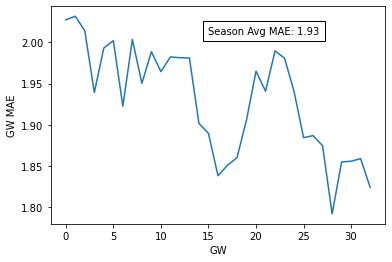

In [31]:
plt.plot(scores)
plt.ylabel('GW MAE')
plt.xlabel('GW')
plt.text(15, 2.01, 'Season Avg MAE: %.2f' % np.mean(scores), bbox={'facecolor':'white', 'alpha':1, 'pad':5})
plt.show()

Looking across the whole season we see about a 10% improvement versus the simple model. Also interesting is that the performance again improves as the season progresses - this makes sense, more data about each of teams and players (particularly new ones) means improved ability to predict the next 6 gameweeks.

Let's add these validation scores to our comparison dataset.

In [32]:
model_validation_scores = pd.read_csv(path/'charts/model_validation_scores.csv', index_col=0)
model_validation_scores['random_forest'] = scores
model_validation_scores.to_csv(path/'charts/model_validation_scores.csv')

A feature of the random forest algorithm is that we can see how often features are being used in trees. This will give us an indication of how important each feature is i.e. is it predictive of todal points scored. Simple models are usually better, so this also gives us a way of seeing if there are any features that are not particularly useful, and can therefore be removed.

In [33]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [34]:
fi = rf_feat_importance(m, X_train)
fi[:32]

cols       imp
1                                  minutes  0.390703
2                           minutes_last_1  0.062769
4                           minutes_last_2  0.047365
78                total_points_pg_last_all  0.040630
92  total_points_team_pg_last_all_opponent  0.031822
5                           minutes_last_3  0.025543
91           total_points_team_pg_last_all  0.023794
73                 total_points_pg_last_10  0.021435
72                  total_points_pg_last_1  0.021153
81   total_points_team_pg_last_10_opponent  0.019175
8                         minutes_last_all  0.018897
80            total_points_team_pg_last_10  0.018479
90    total_points_team_pg_last_5_opponent  0.015740
82    total_points_team_pg_last_1_opponent  0.014120
89             total_points_team_pg_last_5  0.014084
0                                       gw  0.014079
88    total_points_team_pg_last_4_opponent  0.014069
84    total_points_team_pg_last_2_opponent  0.013995
3                          minutes_last_10  0.013986
87             total_points_team_pg_last_4  0.013744
79             total_points_team_pg_last_1  0.013604
86    total_points_team_pg_last_3_opponent  0.013555
83             total_points_team_pg_last_2  0.013284
77                  total_points_pg_last_5  0.012710
85             total_points_team_pg_last_3  0.012654
74                  total_points_pg_last_2  0.012588
75                  total_points_pg_last_3  0.012374
76                  total_points_pg_last_4  0.011731
7                           minutes_last_5  0.008973
6                           minutes_last_4  0.007771
93                                was_home  0.006095
39                              position_2  0.005958

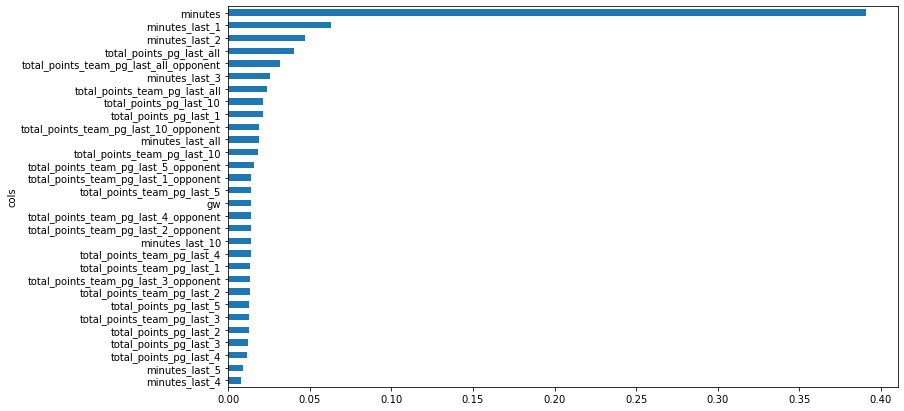

In [35]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False).invert_yaxis()

plot_fi(fi[:30]);

At the moment this algorithm is given minutes played in the gameweek so it's unsurprising that this is by far the most important feature - the more minutes a player plays, the more opportunity to score points. But strictly speaking we don't actually have this information prior to a gameweek (in practice it is estimated using previous minutes and injury status), so we can ignore it for now.

Below that the top features are:
1. minutes_last_1 - number of minutes in the last fixture for the player
2. minutes_last_2 - number of minutes in the last two fixtures for the player
3. total_points_pg_last_all - the player's average points per game in all of history (since start of 2016/17 season)
4. total_points_team_pg_last_all_opponent - the opposition's average points per game in all of history
5. minutes_last_3 - number of minutes in the last three fixtures for the player
6. total_points_team_pg_last_all - the player's team's average points per game in all of history
7. total_points_pg_last_10 - the player's average points per game in the last 10 fixtures
8. total_points_pg_last_1 - the player's average points per game in the last fixture

This is interesting. It seems to be saying that the amount of minutes a player has played recently and their underlying ability to score points in all of history, along with their team's and opponent team's points scoring in all of history, is most important.

Recent performance (i.e. 'form') is also important, but to a lesser extent.

It also shows that the lag features are far more useful than the categorical features such as team, opponent and position. Again not too surprising since information on these categories are already captured in the lag features.

Let's test this... we can remove anything with a feature importance of less than 0.005 and see how the model performs on the original 2019/20 week 20 validation point (going from 94 features to just 32).

In [36]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

32

In [37]:
len(X_train.columns)

94

In [38]:
X_train_imp = X_train[to_keep]
X_test_imp = X_test[to_keep]

In [39]:
m = rf(X_train_imp, y_train.values.ravel())

In [40]:
mae(m.predict(X_test_imp), y_test.values.ravel())
# mae(m.predict(X_train_imp), y_train.values.ravel())

1.897493

Very similar albeit slightly higher error (less than 1% worse performance) than previously, and still a long way ahead of the simple model.

Continuing our thinking about improving/simplifying the model features, we can also look to see if there are any similar features - quite often we will find that some features are so similar that some of them may be redundant.

The following function determines the similarity between columns in a dataset and visualises it using a dendrogram.

In [41]:
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(sp.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

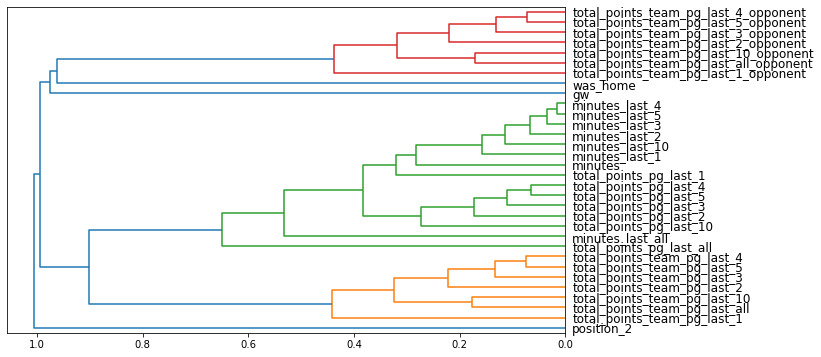

In [42]:
cluster_columns(X_train_imp)

We can see that our lagging features are somewhat similar - absolutely expected since, for example, minutes_last_5 is equal to minutes_last_4 + minutes 5 games ago. They are still different enough to be of value separately, but it does make me wonder whether separating out each historic game in some way (up to a point) would be valuable.

A final useful tool we can use is partial dependency plots. These try to look at the impact of single features on the dependent variable (points scored). 

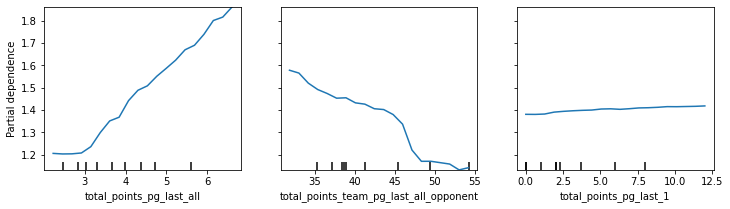

In [45]:
fig,ax = plt.subplots(figsize=(12, 3))
plot_partial_dependence(m, X_test_imp, ['total_points_pg_last_all', 
                                    'total_points_team_pg_last_all_opponent',
                                    'total_points_pg_last_1'],
                        grid_resolution=20, ax=ax);

Again, these make sense. The higher a player's historic points per game (defined as 90 minutes) is, the higher we predict their score will be. Conversely, the higher their opposition's historic points per game, the harder they are as an opponent and the lower their predicted score will be.

Looking at the player's most recent game, again the higher their score, the more it will push up our prediction (the impact of their 'form'), but the relationship is far weaker than the player's underlying per minute scoring stats.

Here we just try to look at features in isolation, there will lots of interactions going on between features that improve performance. For example, a player may have a high 'total_points_pg_last_1' from the previous fixture but only played 5 minutes in total - in this case the algorithm is likely to have learned that a high 'total_points_pg_last_1' coupled with a low 'minutes_last_1' is not an indicator that the player will score higher in the next fixture.

Ok, now we can move onto the next algorithm - xgboost.